# Project 2 - Ames Housing Data and Kaggle Challenge

## 02 Model selection and analyze

### Imports

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from pandas.api.types import CategoricalDtype 
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

%matplotlib inline

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn import metrics
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OrdinalEncoder, OneHotEncoder

In [76]:
# import clean data

train = pd.read_csv('../datasets/train_clean.csv')
test = pd.read_csv('../datasets/test_clean.csv')

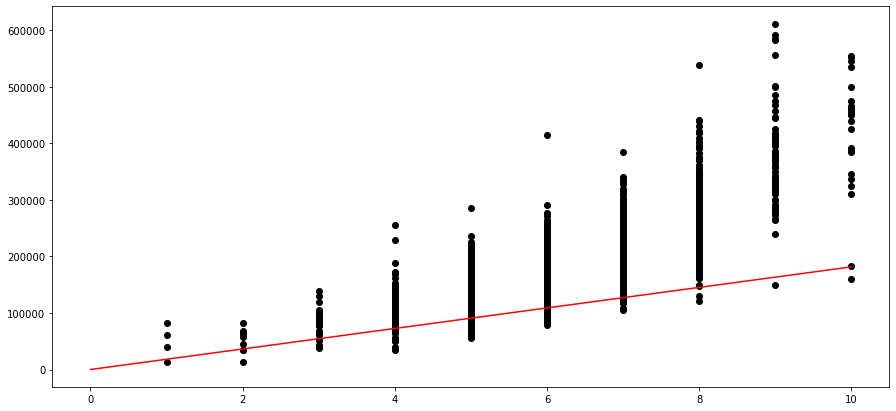

In [77]:
#ploting a baseline model for the top two with highest correlation to saleprice (over all quality)
plt.figure(figsize=(15,7))
plt.scatter(train['overallqual'], train['saleprice'], color='black')
plt.plot((0, 10),(np.mean(train['overallqual']), np.mean(train['saleprice'])),color='red');

In [78]:
# Correlation of numeric data to SalePrice
train.corr()['saleprice'].abs().sort_values(ascending = False).to_frame()

,saleprice
saleprice,1.000000
overallqual,0.800207
grlivarea,0.697038
garagearea,0.649897
garagecars,0.647781
totalbsmtsf,0.629303
1stflrsf,0.618486
yearbuilt,0.571849
yearremod/add,0.550370
fullbath,0.537969


Function for model selection since we have to run through its many times

In [79]:
def model_train_sc_fit(features):
    
    X = train[features]
    X_test = test[features]
    y = train['saleprice']
    
    ss = StandardScaler()
    ss.fit(X)
    X_sc = ss.transform(X)
    X_test_sc = ss.transform(X_test)
    
    lr = LinearRegression()
    lr.fit(X_sc,y)
    
    ridgeCV = RidgeCV()
    ridgeCV.fit(X_sc,y)
    ridge = Ridge(alpha = ridgeCV.alpha_)
    ridge.fit(X_sc,y)
    
    lassoCV = LassoCV()
    lassoCV.fit(X_sc,y)
    lasso = Lasso(alpha=lassoCV.alpha_)
    lasso.fit(X_sc,y)
    
    elCV = ElasticNetCV(l1_ratio=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
    elCV.fit(X_sc,y)
    el = ElasticNet(alpha = elCV.alpha_, l1_ratio = elCV.l1_ratio_)
    el.fit(X_sc,y)

    print('Linear')
    lr_r2_score = lr.score(X_sc,y)
    print("R2 Score:",lr_r2_score)
    lr_cv_r2_xsc = cross_val_score(lr, X_sc, y, cv=5).mean()
    print("R2 CV Score:",lr_cv_r2_xsc)
    lr_cv_rmse_xsc = np.abs(cross_val_score(lr,X_sc,y,cv=5,scoring='neg_root_mean_squared_error')).mean()
    print("RMSE CV:",lr_cv_rmse_xsc)

    print('')
    print('Ridge')
    ridge_r2_score = ridge.score(X_sc,y)
    print("R2 Score:", ridge_r2_score)
    ridge_cv_r2_xsc = cross_val_score(ridge, X_sc, y, cv=5).mean()
    print("R2 CV Score:",ridge_cv_r2_xsc)
    ridge_cv_rmse_xsc = np.abs(cross_val_score(ridge,X_sc,y,cv=5,scoring='neg_root_mean_squared_error')).mean()
    print("RMSE CV:",ridge_cv_rmse_xsc)
    
    print('')
    print('Lasso')
    lasso_r2_score = lasso.score(X_sc,y)
    print("R2 Score:", lasso_r2_score)
    lasso_cv_r2_xsc = cross_val_score(lasso, X_sc, y, cv=5).mean()
    print("R2 CV Score",lasso_cv_r2_xsc)
    lasso_cv_rmse_xsc = np.abs(cross_val_score(lasso,X_sc,y,cv=5,scoring='neg_root_mean_squared_error')).mean()
    print("RMSE CV:",lasso_cv_rmse_xsc)
    
    print('')
    print('ElasticNet')
    el_r2_score = el.score(X_sc,y)
    print("R2 Score:", el_r2_score)
    el_cv_r2_xsc = cross_val_score(el, X_sc, y, cv=5).mean()
    print("R2 CV Score",el_cv_r2_xsc)
    el_cv_rmse_xsc = np.abs(cross_val_score(el,X_sc,y,cv=5,scoring='neg_root_mean_squared_error')).mean()
    print("RMSE CV:",el_cv_rmse_xsc)
    
    if lr_cv_r2_xsc >= ridge_cv_r2_xsc and lr_cv_r2_xsc >= el_cv_r2_xsc and lr_cv_r2_xsc >= lasso_cv_r2_xsc:
        print('')
        print('Linear is the best')
        lr.fit(X_sc,y)
        y_pred = lr.predict(X_test_sc)
    elif ridge_cv_r2_xsc >= lr_cv_r2_xsc and ridge_cv_r2_xsc >= el_cv_r2_xsc and ridge_cv_r2_xsc >= lasso_cv_r2_xsc:
        print('')
        print('Ridge is the best')
        ridge.fit(X_sc,y)
        y_pred = ridge.predict(X_test_sc)
    elif lasso_cv_r2_xsc >= lr_cv_r2_xsc and lasso_cv_r2_xsc >= el_cv_r2_xsc and lasso_cv_r2_xsc >= ridge_cv_r2_xsc:
        print('')
        print(f'Lasso alpha: {lassoCV.alpha_}')
        print('Lasso is the best')
        ridge.fit(X_sc,y)
        y_pred = ridge.predict(X_test_sc) 
    else: 
        print('')
        print('ElasticNet is the best')
        el.fit(X_sc,y)
        y_pred = el.predict(X_test_sc)
        
    return y_pred

## Model selection

## Model 1

###### Clean data with correlation more than 40%

This model select features with correlation more than 40%

In [80]:
df = train.corr()['saleprice'].abs().sort_values(ascending = False).to_frame()
ori_40 = df[df['saleprice']>0.4].index.tolist()
ori_40.remove('saleprice')

In [81]:
#select feature with corr more than 40%
features = ori_40

In [82]:
y_pred = model_train_sc_fit(features)

Linear
R2 Score: 0.8087418370957801
R2 CV Score: 0.7996077548927032
RMSE CV: 35223.738701753944

Ridge
R2 Score: 0.8087341361333025
R2 CV Score: 0.7999519311868889
RMSE CV: 35198.198591020046

Lasso
R2 Score: 0.8082952576069697
R2 CV Score 0.8012476156436223
RMSE CV: 35108.9028753919

ElasticNet
R2 Score: 0.8082952576069697
R2 CV Score 0.8012476156436223
RMSE CV: 35108.9028753919

Lasso alpha: 838.2145965960797
Lasso is the best


#### Lasso model have highest R2 cross validation score at 80.12%

In [83]:
# export file for submission
pd.DataFrame(data = {'Id': test['id'],'SalePrice': y_pred}).to_csv('../datasets/model1.csv',index=False)

## Model 2

This model select all features in clean data
Compare to model 1, model 1 is better with slightly higher R2 score

In [84]:
#select all features
features2 = [f for f in train._get_numeric_data().columns if f !='saleprice' and f !='id' and f !='pid']

In [85]:
y_pred2 = model_train_sc_fit(features2)

Linear
R2 Score: 0.840327544510518
R2 CV Score: 0.8031169744713983
RMSE CV: 34890.56899497246

Ridge
R2 Score: 0.84031826849247
R2 CV Score: 0.8037738703594147
RMSE CV: 34834.62155937089

Lasso
R2 Score: 0.8366399240878512
R2 CV Score 0.8070787861094345
RMSE CV: 34536.11157615392

ElasticNet
R2 Score: 0.8366399240878512
R2 CV Score 0.8070787861094345
RMSE CV: 34536.11157615392

Lasso alpha: 898.790036940582
Lasso is the best


#### Lasso model have highest R2 cross validation score at 80.71%

In [86]:
# export file for submission
pd.DataFrame(data = {'Id': test['id'],'SalePrice': y_pred2}).to_csv('../datasets/model2.csv',index=False)

## Model 3

Clean and encoded data with coefficient > 40%

In [87]:
# import encoded data

train = pd.read_csv('../datasets/train_encoded.csv')
test = pd.read_csv('../datasets/test_encoded.csv')

In [88]:
# Correlation to SalePrice
train.corr()['saleprice'].abs().sort_values(ascending = False).to_frame()

,saleprice
saleprice,1.000000
overallqual,0.800207
exterqual,0.712146
grlivarea,0.697038
kitchenqual,0.692336
garagearea,0.649897
garagecars,0.647781
totalbsmtsf,0.629303
1stflrsf,0.618486
bsmtqual,0.612188


In [89]:
df = train.corr()['saleprice'].abs().sort_values(ascending = False).to_frame()
enc_40 = df[df['saleprice']>0.4].index.tolist()
enc_40.remove('saleprice')

In [90]:
#select feature of encoded data with corr more than 40%
features3 = enc_40

In [91]:
y_pred3 = model_train_sc_fit(features3)

Linear
R2 Score: 0.8391037648100027
R2 CV Score: 0.8290191139482666
RMSE CV: 32547.559883370624

Ridge
R2 Score: 0.8390974499150183
R2 CV Score: 0.8293235211972657
RMSE CV: 32522.54601205571

Lasso
R2 Score: 0.8386952333378833
R2 CV Score 0.8301693418815574
RMSE CV: 32453.447730880744

ElasticNet
R2 Score: 0.8386952333378833
R2 CV Score 0.8301693418815574
RMSE CV: 32453.447730880744

Lasso alpha: 479.65720991566974
Lasso is the best


#### Lasso model have highest R2 cross validation score at 83.02%

In [92]:
# export file for submission
pd.DataFrame(data = {'Id': test['id'],'SalePrice': y_pred3}).to_csv('../datasets/model3.csv',index=False)

## Model 4

Clean and encoded data with all columns

In [93]:
#select all features
features4 = [f for f in train.columns if f !='saleprice' and f !='id' and f !='pid']

In [94]:
y_pred4 = model_train_sc_fit(features4)

Linear
R2 Score: 0.931335104021353
R2 CV Score: -9.944066166933326e+23
RMSE CV: 4.6589354032166696e+16

Ridge
R2 Score: 0.9312845762038929
R2 CV Score: 0.8544161636954197
RMSE CV: 29748.250261109584

Lasso
R2 Score: 0.9247054424320258
R2 CV Score 0.8634472017960271
RMSE CV: 28785.091617303155

ElasticNet
R2 Score: 0.9247054424320258
R2 CV Score 0.8634472017960271
RMSE CV: 28785.091617303155

Lasso alpha: 479.65720991566974
Lasso is the best


#### Lasso model have highest R2 cross validation score at 86.34%

In [95]:
# export file for submission
pd.DataFrame(data = {'Id': test['id'],'SalePrice': y_pred4}).to_csv('../datasets/model4.csv',index=False)

## Model 5

Clean, encoded data and remove outliers coefficeint > 40%

In [96]:
# import remove outliers data

train = pd.read_csv('../datasets/train_ole.csv')
test = pd.read_csv('../datasets/test_ole.csv')

In [97]:
train.head()

,lotfrontage,lotarea,street,alley,lotshape,utilities,landslope,overallqual,overallcond,yearbuilt,yearremod/add,masvnrarea,exterqual,extercond,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heatingqc,centralair,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscval,mosold,yrsold,saleprice,miscfeature_Elev,miscfeature_Gar2,miscfeature_NA,miscfeature_Othr,miscfeature_Shed,miscfeature_TenC,mssubclass_20,mssubclass_30,mssubclass_40,mssubclass_45,mssubclass_50,mssubclass_60,mssubclass_70,mssubclass_75,mssubclass_80,mssubclass_85,mssubclass_90,mssubclass_120,mssubclass_150,mssubclass_160,mssubclass_180,mssubclass_190,garagetype_2Types,garagetype_Attchd,garagetype_Basment,garagetype_BuiltIn,garagetype_CarPort,garagetype_Detchd,garagetype_NA,masvnrtype_BrkCmn,masvnrtype_BrkFace,masvnrtype_CBlock,masvnrtype_NA,masvnrtype_None,masvnrtype_Stone,mszoning_A (agr),mszoning_C (all),mszoning_FV,mszoning_I (all),mszoning_RH,mszoning_RL,mszoning_RM,heating_Floor,heating_GasA,heating_GasW,heating_Grav,heating_OthW,heating_Wall,landcontour_Bnk,landcontour_HLS,landcontour_Low,landcontour_Lvl,lotconfig_Corner,lotconfig_CulDSac,lotconfig_FR2,lotconfig_FR3,lotconfig_Inside,neighborhood_Blmngtn,neighborhood_Blueste,neighborhood_BrDale,neighborhood_BrkSide,neighborhood_ClearCr,neighborhood_CollgCr,neighborhood_Crawfor,neighborhood_Edwards,neighborhood_Gilbert,neighborhood_Greens,neighborhood_GrnHill,neighborhood_IDOTRR,neighborhood_Landmrk,neighborhood_MeadowV,neighborhood_Mitchel,neighborhood_NAmes,neighborhood_NPkVill,neighborhood_NWAmes,neighborhood_NoRidge,neighborhood_NridgHt,neighborhood_OldTown,neighborhood_SWISU,neighborhood_Sawyer,neighborhood_SawyerW,neighborhood_Somerst,neighborhood_StoneBr,neighborhood_Timber,neighborhood_Veenker,condition1_Artery,condition1_Feedr,condition1_Norm,condition1_PosA,condition1_PosN,condition1_RRAe,condition1_RRAn,condition1_RRNe,condition1_RRNn,condition2_Artery,condition2_Feedr,condition2_Norm,condition2_PosA,condition2_PosN,condition2_RRAe,condition2_RRAn,condition2_RRNn,bldgtype_1Fam,bldgtype_2fmCon,bldgtype_Duplex,bldgtype_Twnhs,bldgtype_TwnhsE,housestyle_1.5Fin,housestyle_1.5Unf,housestyle_1Story,housestyle_2.5Fin,housestyle_2.5Unf,housestyle_2Story,housestyle_SFoyer,housestyle_SLvl,roofstyle_Flat,roofstyle_Gable,roofstyle_Gambrel,roofstyle_Hip,roofstyle_Mansard,roofstyle_Shed,roofmatl_ClyTile,roofmatl_CompShg,roofmatl_Membran,roofmatl_Metal,roofmatl_Roll,roofmatl_Tar&Grv,roofmatl_WdShake,roofmatl_WdShngl,exterior1st_AsbShng,exterior1st_AsphShn,exterior1st_BrkComm,exterior1st_BrkFace,exterior1st_CBlock,exterior1st_CemntBd,exterior1st_HdBoard,exterior1st_ImStucc,exterior1st_MetalSd,exterior1st_Plywood,exterior1st_PreCast,exterior1st_Stone,exterior1st_Stucco,exterior1st_VinylSd,exterior1st_Wd Sdng,exterior1st_WdShing,exterior2nd_AsbShng,exterior2nd_AsphShn,exterior2nd_Brk Cmn,exterior2nd_BrkFace,exterior2nd_CBlock,exterior2nd_CmentBd,exterior2nd_HdBoard,exterior2nd_ImStucc,exterior2nd_MetalSd,exterior2nd_Other,exterior2nd_Plywood,exterior2nd_PreCast,exterior2nd_Stone,exterior2nd_Stucco,exterior2nd_VinylSd,exterior2nd_Wd Sdng,exterior2nd_Wd Shng,foundation_BrkTil,foundation_CBlock,foundation_PConc,foundation_Slab,foundation_Stone,foundation_Wood,electrical_FuseA,electrical_FuseF,electrical_FuseP,electrical_Mix,electrical_SBrkr,electrical_nan,saletype_COD,saletype_CWD,saletype_Con,saletype_ConLD,saletype_ConLI,saletype_ConLw,saletype_New,saletype_Oth,saletype_VWD,saletype_WD
0,69.0552,13517,2.0,0.0,3.0,4.0,3.0,6,8,1976,2005,289.0,4.0,3.0,3.0,3.0,1.0,6.0,533.0,1.0,0.0,192.0,725.0,5.0,1.0,725,754,0,1479,0.0,0.0,2,1,3,1,4.0,6,7.0,0,0.0,1976.0,2.0,2.0,475.0,3.0,3.0,2.0,0,44,0,0,0,0,0

In [98]:
train.shape

(1977, 243)

In [99]:
# Correlation to SalePrice
train.corr()['saleprice'].abs().sort_values(ascending = False).to_frame()

,saleprice
saleprice,1.000000
overallqual,0.807625
exterqual,0.709091
grlivarea,0.693164
kitchenqual,0.681248
garagecars,0.653439
garagearea,0.646600
totalbsmtsf,0.621688
bsmtqual,0.619012
yearbuilt,0.615595


In [100]:
df = train.corr()['saleprice'].abs().sort_values(ascending = False).to_frame()
ole_40 = df[df['saleprice']>0.4].index.tolist()
ole_40.remove('saleprice')

In [101]:
#select feature of encoded data with corr more than 40%
features5 = ole_40

In [102]:
y_pred5 = model_train_sc_fit(features5)

Linear
R2 Score: 0.861230790430819
R2 CV Score: 0.8561271784125533
RMSE CV: 25120.4853341785

Ridge
R2 Score: 0.8612185024745294
R2 CV Score: 0.8562091277972581
RMSE CV: 25115.203484939015

Lasso
R2 Score: 0.8612034507761153
R2 CV Score 0.8561225781102924
RMSE CV: 25122.212687657506

ElasticNet
R2 Score: 0.8612034507761153
R2 CV Score 0.8561225781102924
RMSE CV: 25122.212687657506

Ridge is the best


#### Ridge model have highest R2 cross validation score at 85.62%

In [103]:
# export file for submission
pd.DataFrame(data = {'Id': test['id'],'SalePrice': y_pred5}).to_csv('../datasets/model5.csv',index=False)

## Model 6

Clean, encoded data and remove outliers with all columns

In [104]:
#select all features
features6 = [f for f in train.columns if f !='saleprice' and f !='id' and f !='pid']

In [105]:
y_pred6 = model_train_sc_fit(features6)

Linear
R2 Score: 0.9319893664532468
R2 CV Score: -4.924422226939924e+24
RMSE CV: 1.135090949596514e+17

Ridge
R2 Score: 0.9319409466610457
R2 CV Score: 0.9082950508807371
RMSE CV: 20066.169226894486

Lasso
R2 Score: 0.9277402371152352
R2 CV Score 0.9133517309977421
RMSE CV: 19493.688811886084

ElasticNet
R2 Score: 0.9277402371152352
R2 CV Score 0.9133517309977421
RMSE CV: 19493.688811886084

Lasso alpha: 286.51306844914535
Lasso is the best


#### Lasso model have highest R2 cross validation score at 91.34%

In [106]:
# export file for submission
pd.DataFrame(data = {'Id': test['id'],'SalePrice': y_pred6}).to_csv('../datasets/model6.csv',index=False)

### Model 4 was selected as a final model

This model select features all features from data **without outliers**

As model 4 got lower R2 cross validation score and RMSE in train data compare with model 6 but at this point  model 4 shows that RMSE score in train data and test data in kaggle was closed together, which mean model 4 is not to be overfitted compare to model 6

| Model | Description | R2 CV Score | RMSE on train | RMSE on Kaggle |
| --- | --- | --- | --- | --- |
|Model1: Lasso| Numerical cleaned data with cofficient > 40% | 80.12% | 35108 | 33266 |
|Model2: Lasso| All numerical cleaned data| 80.71% | 34536 | 33425 |
|Model3: Lasso| Encoded and cleaned data with cofficient > 40% | 83.02% | 32453 | 33063 |
|Model4: Lasso| All encoded and cleaned data| 86.34% | 28785 | 27754 |
|Model5: Ridge| Encoded and cleaned data with cofficient > 40% | 85.62% | 25115 | 34358 |
|Model6: Lasso| All encoded and cleaned data| 91.34% | 28785 | 27808 |



## Final model with features selection

Increase alpha to reduce variance

Function for tuning model with manual inout alpha

In [107]:
def model_train_sc_fit_alpha(features,alpha):
    
    X = train[features]
    X_test = test[features]
    y = train['saleprice']
    
    ss = StandardScaler()
    ss.fit(X)
    X_sc = ss.transform(X)
    X_test_sc = ss.transform(X_test)
    
    lr = LinearRegression()
    lr.fit(X_sc,y)

    ridge = Ridge(alpha = alpha)
    ridge.fit(X_sc,y)

    lasso = Lasso(alpha=alpha)
    lasso.fit(X_sc,y)
    
    elCV = ElasticNetCV(l1_ratio=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
    elCV.fit(X_sc,y)
    el = ElasticNet(alpha = alpha, l1_ratio = elCV.l1_ratio_)
    el.fit(X_sc,y)

    print('Linear')
    lr_r2_score = lr.score(X_sc,y)
    print("R2 Score:",lr_r2_score)
    lr_cv_r2_xsc = cross_val_score(lr, X_sc, y, cv=5).mean()
    print("R2 CV Score:",lr_cv_r2_xsc)
    lr_cv_rmse_xsc = np.abs(cross_val_score(lr,X_sc,y,cv=5,scoring='neg_root_mean_squared_error')).mean()
    print("RMSE CV:",lr_cv_rmse_xsc)

    print('')
    print('Ridge')
    ridge_r2_score = ridge.score(X_sc,y)
    print("R2 Score:", ridge_r2_score)
    ridge_cv_r2_xsc = cross_val_score(ridge, X_sc, y, cv=10).mean()
    print("R2 CV Score:",ridge_cv_r2_xsc)
    ridge_cv_rmse_xsc = np.abs(cross_val_score(ridge,X_sc,y,cv=5,scoring='neg_root_mean_squared_error')).mean()
    print("RMSE CV:",ridge_cv_rmse_xsc)
    
    print('')
    print('Lasso')
    lasso_r2_score = lasso.score(X_sc,y)
    print("R2 Score:", lasso_r2_score)
    lasso_cv_r2_xsc = cross_val_score(lasso, X_sc, y, cv=5).mean()
    print("R2 CV Score",lasso_cv_r2_xsc)
    lasso_cv_rmse_xsc = np.abs(cross_val_score(lasso,X_sc,y,cv=5,scoring='neg_root_mean_squared_error')).mean()
    print("RMSE CV:",lasso_cv_rmse_xsc)
    
    print('')
    print('ElasticNet')
    el_r2_score = el.score(X_sc,y)
    print("R2 Score:", el_r2_score)
    el_cv_r2_xsc = cross_val_score(el, X_sc, y, cv=5).mean()
    print("R2 CV Score",el_cv_r2_xsc)
    el_cv_rmse_xsc = np.abs(cross_val_score(el,X_sc,y,cv=5,scoring='neg_root_mean_squared_error')).mean()
    print("RMSE CV:",el_cv_rmse_xsc)
    
    if lr_cv_r2_xsc >= ridge_cv_r2_xsc and lr_cv_r2_xsc >= el_cv_r2_xsc and lr_cv_r2_xsc >= lasso_cv_r2_xsc:
        print('')
        print('Linear is the best')
        y_pred = lr.predict(X_test_sc)
        
        
    elif ridge_cv_r2_xsc >= lr_cv_r2_xsc and ridge_cv_r2_xsc >= el_cv_r2_xsc and ridge_cv_r2_xsc >= lasso_cv_r2_xsc:
        print('')
        print('Ridge is the best')
        coef_labels = [col for col in train.columns if col != 'saleprice' and col != 'id' and col != 'pid'] 
        ridge_coef = pd.DataFrame(ridge.coef_, index = coef_labels)
        ridge_coef = ridge_coef[ridge_coef[0] != 0]  
        print(f'Ridge has {ridge_coef.shape[0]} non-zero coefficients.')
        y_pred = ridge.predict(X_test_sc)
        
    elif lasso_cv_r2_xsc >= lr_cv_r2_xsc and lasso_cv_r2_xsc >= el_cv_r2_xsc and lasso_cv_r2_xsc >= ridge_cv_r2_xsc:
        print('')
        print('Lasso is the best')
        coef_labels = [col for col in train.columns if col != 'saleprice' and col != 'id' and col != 'pid'] 
        lasso_coef = pd.DataFrame(lasso.coef_, index = coef_labels)
        lasso_coef = lasso_coef[lasso_coef[0] != 0]  
        print(f'this model has {lasso_coef.shape[0]} non-zero coefficients.')
        y_pred = lasso.predict(X_test_sc) 
        
        # sort by absolute values
        lasso_coef = lasso_coef.reindex(lasso_coef[0].abs().sort_values(ascending=True).index)
        
        lasso_coef.tail(20).plot.barh(figsize=(15,10), legend = None)
        plt.title('top 20 features with the highest coefficients',fontsize=14)
        plt.xlabel('coefficient', fontsize=12)
        plt.yticks(fontsize=12)
        plt.tight_layout()
        
    else: 
        print('')
        print('ElasticNet is the best')
        coef_labels = [col for col in train.columns if col != 'saleprice' and col != 'id' and col != 'pid'] 
        el_coef = pd.DataFrame(el.coef_, index = coef_labels)
        el_coef = el_coef[el_coef[0] != 0]
        print(f'this model has {el_coef.shape[0]} non-zero coefficients.')
        y_pred = el.predict(X_test_sc)
        
        # sort by absolute values
        el_coef = el_coef.reindex(el_coef[0].abs().sort_values(ascending=True).index)

        # plot top 20 coefficients
        el_coef.tail(20).plot.barh(figsize=(15,10), legend = None)
        plt.title('top 20 features with the highest coefficients',fontsize=14)
        plt.xlabel('coefficient', fontsize=12)
        plt.yticks(fontsize=12)
        plt.tight_layout()

    return y_pred

In [108]:
# import encoded data which use in selected model 4

train = pd.read_csv('../datasets/train_encoded.csv')
test = pd.read_csv('../datasets/test_encoded.csv')

Linear
R2 Score: 0.931335104021353
R2 CV Score: -9.944066166933326e+23
RMSE CV: 4.6589354032166696e+16

Ridge
R2 Score: 0.9004675288910928
R2 CV Score: 0.8580061274900996
RMSE CV: 29391.554793229217

Lasso
R2 Score: 0.908382532729695
R2 CV Score 0.8586109572974617
RMSE CV: 29403.24806725096

ElasticNet
R2 Score: 0.908382532729695
R2 CV Score 0.8586109572974617
RMSE CV: 29403.24806725096

Lasso is the best
this model has 52 non-zero coefficients.


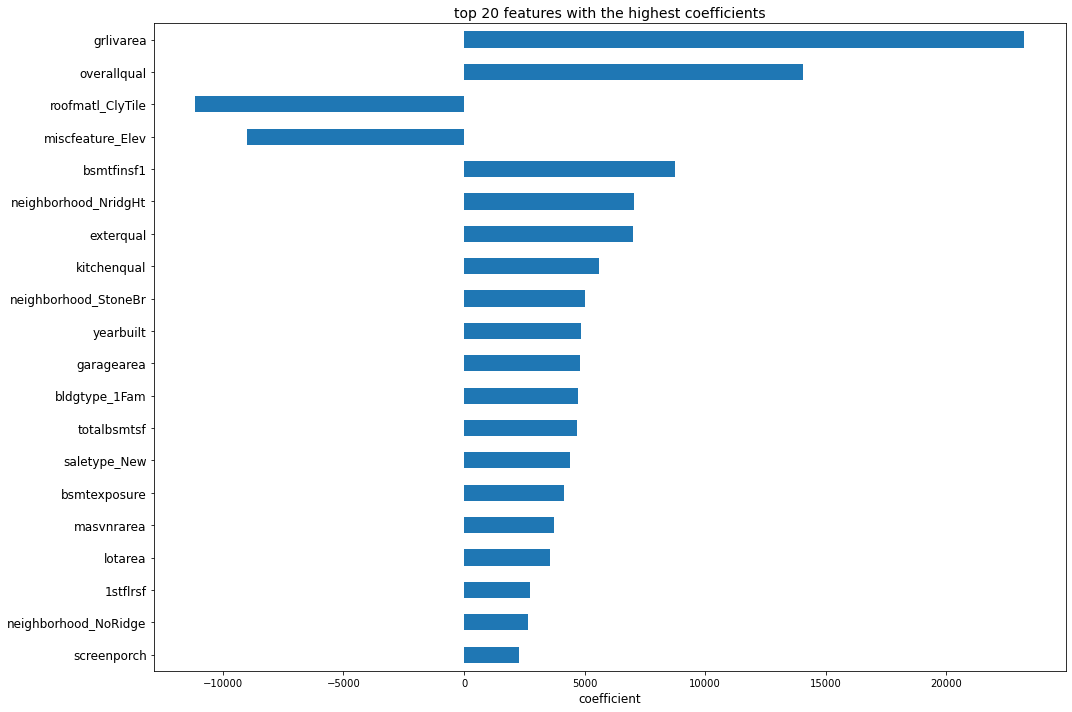

In [109]:
y_pred7 = model_train_sc_fit_alpha(features6,1500)

#### Lasso model with alpha 1500 have highest R2 score at 85.86%

In [110]:
# export file for submission
pd.DataFrame(data = {'Id': test['id'],'SalePrice': y_pred7}).to_csv('../datasets/model_final.csv',index=False)

### Analysis of final model

In [111]:
final_features = [f for f in train.columns if f !='saleprice' and f !='id' and f !='pid']

In [112]:
X = train[final_features]
X_test = test[final_features]
y = train['saleprice']
    
ss = StandardScaler()
ss.fit(X)
X_sc = ss.transform(X)
X_test_sc = ss.transform(X_test)

lasso = Lasso(alpha=1500)
lasso.fit(X_sc,y)

y_train_pred = lasso.predict(X_sc) 
y_pred = lasso.predict(X_test_sc) 


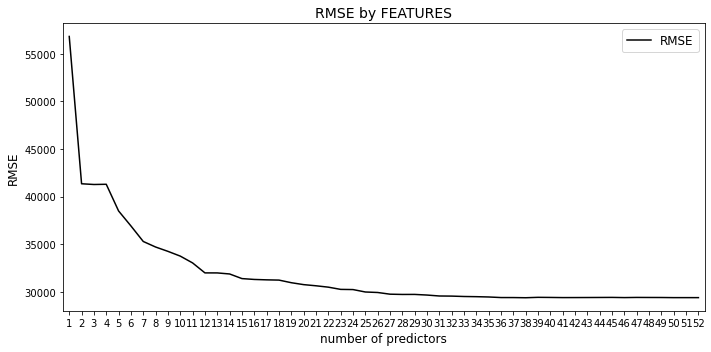

In [120]:
# ------------------------- PLOT FEATURES NO. PREDICTORS -----------------------------#

coef_labels = [col for col in train.columns if col != 'saleprice' and col != 'id' and col != 'pid'] 
lasso_coef = pd.DataFrame(lasso.coef_, index = coef_labels)
lasso_coef = lasso_coef[lasso_coef[0] != 0]  
y_pred = lasso.predict(X_test_sc) 
        
# sort by absolute values
lasso_coef = lasso_coef.reindex(lasso_coef[0].abs().sort_values(ascending=True).index)

# put the test data into a dataframe so they can be sliced
xtrain_df = pd.DataFrame(X_sc, columns = coef_labels)

# for each number of predictors in the 52 non-zero predictors, compute validation set error (MSE) and SE
# starting from the predictor with the highest coefficient
n_predictors = 52
rmse_mean = []
rmse_se = []
for n in range(1,n_predictors+1):
    predictors = lasso_coef.index[-n:]  # coefficients are sorted by absolute values, highest at bottom
    xtrain_sliced = xtrain_df[predictors]   # slice out just that predictor from xtest_scaled
    # get validation set MSE and MSE variance
    cv_scores = -cross_val_score(lasso, xtrain_sliced, y, scoring = 'neg_root_mean_squared_error', cv = 5)
    rmse_mean.append(cv_scores.mean())
    rmse_se.append(cv_scores.std()/np.sqrt(5))

# ------------------------- PLOT FEATURES NO. PREDICTORS -----------------------------#
fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize=(10,5))

# PLOT WITH 52 PREDICTORS

ax.plot(np.arange(1,n_predictors+1,1), rmse_mean, 'k', label = 'RMSE')


# there does not seem to be significant declines in RMSE beyond 30 predictors
# plot line for the RMSE of 30 predictors, + 1 SE

ax.set_title('RMSE by FEATURES', fontsize=14)
ax.set_ylabel('RMSE', fontsize = 12)
ax.set_xlabel('number of predictors', fontsize = 12)
ax.set_xticks(np.arange(1,53,1))
ax.set_xlim(0.5, 52 + 0.5)
ax.legend(loc = 'upper right',  prop={'size': 12})

plt.tight_layout()

##### Analysis of final model and conclusion

In Model 4, lasso regression model was selected as its had best prediction value on house price in AMES shows in Kaggle out perform other linear regression models.  

After increased alpha ny 1500 to elimited the features, afterall we have got final 52 features (if count  same categorical as 1 features it will be final at 39 features) with RMSE in train data at 29403 and on Kaggle at 29377.

**This showing that the final model can predict the house price +- around $29000**

As of lasso was able to reveal which features affect sale price the most.

The validation set errors are then plotted against number of predictors. RMSE appears to stop decreasing significantly from 30 predictors onwards.  
Therefore, for the purpose of having a simpler and more easily interpretable model, look closer at 15 predictors onward RMSE tend to slightly decrese which the top 15 predictors will be used for the interpret the model which are:


|Features|Coefficient|
|---|---|
|grlivarea|3223.872588|
|overallqual|14035.774287|
|bsmtfinsf1|8729.217990|
|neighborhood_NridgHt	|7050.805490|
|exterqual	|6996.110155|
|kitchenqual	|5595.558339|
|neighborhood_StoneBr	|5021.050500|
|yearbuilt	|4839.733343|
|garagearea	|4799.303515|
|bldgtype_1Fam	|4738.694615|
|totalbsmtsf	|4677.522978|
|saletype_New	|4373.543453|
|bsmtexposure	|4130.057381| 
|miscfeature_Elev	|-8993.741428|
|roofmatl_ClyTile	|-11156.215150|

##### In conclusion the factors the reslut to house price that owner should consider: 
<ul>
    <li>Above ground living area</li>
    <li>Quality of overall condition </li>
    <li>Age of the house</li>
    <li>House in the area of Northridge Heights, Stone Brook are likely to have a good price</li>
    <li>Size of garage</li>
    <li>House with single family Detached</li>
    <li>Size of the basement</li>
    <li>New constructed house appears to have better sale price</li>
    <li>Size of the basement</li>
    <li>Lot size </li>
    <li>property has significant slope from side to side </li>
</ul> 

##### Value added to the house:  
<ul>
    <li>Renovate basement finished area (if exist)</li>
    <li>Renovate external area of the house</li>
    <li>Renovate kitchen </li>
    <li>Renovate basement with good exposure </li>
</ul> 
    
##### Thing that should avoid:  
<ul>
    <li>Clay or Tile roof material </li>
    <li>Elevator in the house</li>
</ul> 

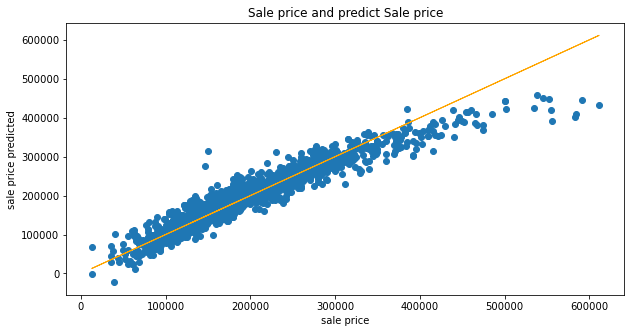

In [114]:
plt.figure(figsize=(10,5))
plt.scatter(y, y_train_pred)
plt.plot(y, y, color='orange', linewidth=1)
plt.title('Sale price and predict Sale price')
plt.xlabel('sale price')
plt.ylabel('sale price predicted')
plt.show()

Count same category as 1 features

In [115]:
def count_features(x):
    sep = '_'
    x = x.split(sep, 1)[0]
    return x

In [116]:
features_list = [count_features(feature) for feature in lasso_coef.index.to_list()]

In [117]:
len(set(features_list))

39

In [118]:
lasso_coef.tail(15).sort_values(by = 0, ascending = False)

,0
grlivarea,23223.872588
overallqual,14035.774287
bsmtfinsf1,8729.217990
neighborhood_NridgHt,7050.805490
exterqual,6996.110155
kitchenqual,5595.558339
neighborhood_StoneBr,5021.050500
yearbuilt,4839.733343
garagearea,4799.303515
bldgtype_1Fam,4738.694615
